#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
from colour import sd_to_XYZ, XYZ_to_xy, XYZ_to_sRGB
from scipy.spatial import ConvexHull
%matplotlib widget

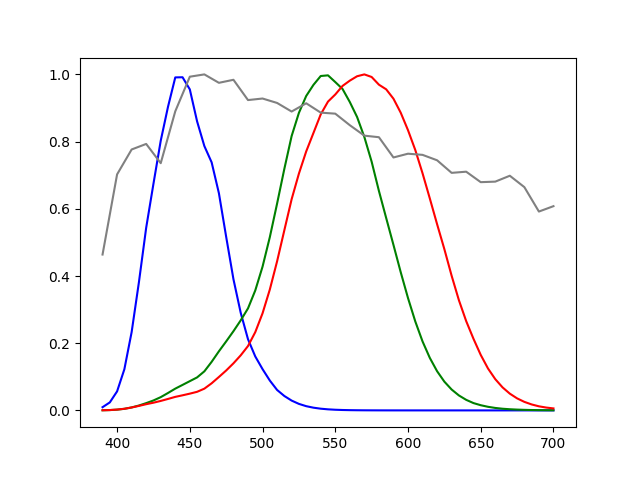

In [2]:
# Cone responses of a typical trichromat.
fig, ax = plt.subplots()
wavelengths = np.arange(390, 701, 5)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
illuminant_colour = illuminant.to_colour()
chromaticity_coord = XYZ_to_xy(sd_to_XYZ(illuminant_colour) / 100)

standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
illuminant.plot(color="gray")

plt.show()

In [3]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
lms_responses = np.vstack((standard_trichromat.sensors[0].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[2].data)) * illuminant.data

# Uses ideas from Jessica's paper, on chapter 3.2 The Max Basis.
# We use the cutpoints that Jessica shows to be optimal for the trichromatic case.
cutpoint_1 = 487
cutpoint_2 = 573
index_1 = None
index_2 = None
for i, wavelength in enumerate(wavelengths):
    if index_1 is None and wavelength > cutpoint_1:
        index_1 = i
    if index_2 is None and wavelength >= cutpoint_2:
        index_2 = i
        break

# We calculate the vectors p1, p2 and p3 as shown in the paper.
# We "project the partition into the cone response basis" by summing up all the lms_responses within each partition.
# Note that our earlier calculations for lms_responses includes the illuminant already.
p1 = np.sum(lms_responses[:, :index_1], axis=1).reshape((3, 1))
p2 = np.sum(lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
p3 = np.sum(lms_responses[:, index_2:], axis=1).reshape((3, 1))

# We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
# p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
# and we are mapping them onto the R, G, B points on the RGB cube.
# We are essentially "stretching" our object color solid so that it approximates the RGB cube.
transformation_matrix = np.linalg.inv(np.hstack((p1, p2, p3)))
points = np.matmul(transformation_matrix, lms_responses).T

In [4]:
# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]

# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in tqdm(range(1, n)):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        
        # Calculate the reflectance on each face by using the reflectance of one of its vertices.
        # Since each vertex can be thought of as a linear combination of the basis vectors, 
        # the vertex's reflectance is the sum of reflectances of those vectors that made up the vertex.
        reflectance_data = np.zeros(n)
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        face_colors[(i - 1) * n + j] = reflectance.to_rgb(illuminant)    # Bottleneck. Takes about 3ms. 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:18<00:00,  3.37it/s]


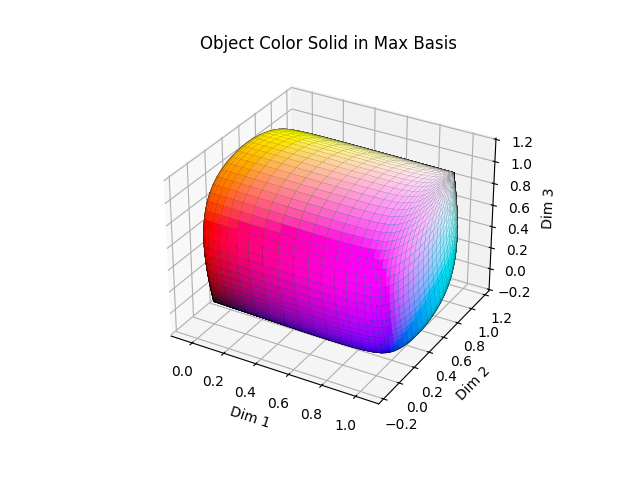

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.05, edgecolors='k')
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('Object Color Solid in Max Basis')
plt.show()

In [6]:
# Builds up the vertices from the set of generating vectors.
# Specifies the XYZ color coordinates of each vertex. 
# Note that the XYZ color space is linear.
vertices = np.zeros((n + 1, n, 3))
vertices_xyz = np.zeros((n + 1, n, 3))
for i in tqdm(range(1, n + 1)):
    for j in range(n):
        reflectance_data = np.zeros(n)
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        vertices_xyz[i, j] = sd_to_XYZ(reflectance.to_colour(), illuminant=illuminant_colour) / 100

# Builds up the set of edges from the diagram in (8).
# There are 2 * (n ** 2) edges in total where n is the number of generating vectors.
# edges_xyz specifies the XYZ color coordinates of its two endpoints.
edges = np.zeros((2 * (n ** 2), 2, 3))
edges_xyz = np.zeros((2 * (n ** 2), 2, 3))
index = 0
for j in range(n):
    # Vertical edges.
    for i in range(n):
        edges[index][0] = vertices[i][j]
        edges[index][1] = vertices[i + 1][j]
        edges_xyz[index][0] = vertices_xyz[i][j]
        edges_xyz[index][1] = vertices_xyz[i + 1][j]
        index += 1
        
    # Diagonal edges.
    for i in range(1, n + 1):
        edges[index][0] = vertices[i][j]
        edges[index][1] = vertices[i - 1][(j + 1) % n]
        edges_xyz[index][0] = vertices_xyz[i][j]
        edges_xyz[index][1] = vertices_xyz[i - 1][(j + 1) % n]
        index += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:04<00:00, 14.57it/s]


In [7]:
# Iterates through each edge and checks whether it intersects the plane.
# If it does, store the coordinates of the intersection and the XYZ color coordinates of the intersection.
# The XYZ color coordinates is obtained from taking a linear combination of the XYZ color coordinates of its endpoints.
# ax + by + cz + d = 0
a = 0.7
b = 0.4
c = 0.9
d = -0.8

intersection_points = []
intersection_xyz = []
for i in range(edges.shape[0]):
    p1 = edges[i][0]
    p2 = edges[i][1]
    v = p2 - p1
    denom = a * v[0] + b * v[1] + c * v[2]
    if abs(denom) < 1e-6:    # Edge is parallel to plane.
        continue
    t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
    if 0 <= t <= 1:
        i_point = ((1 - t) * p1) + (t * p2)
        i_xyz = ((1 - t) * edges_xyz[i][0]) + (t * edges_xyz[i][1])
        intersection_points.append(i_point)
        intersection_xyz.append(i_xyz)
assert len(intersection_points) > 0, "No intersection points"
intersection_rgb = []
for i_xyz in intersection_xyz:
    intersection_rgb.append(np.clip(XYZ_to_sRGB(i_xyz, illuminant=chromaticity_coord), 0, 1))

# In the end, we obtain an array of points along the boundary of the intersection and their RGB values.
intersection_points = np.array(intersection_points)
intersection_rgb = np.array(intersection_rgb)

In [8]:
# We then connect these vertices together to form the outline of the intersection.
# We do this by first projecting the points onto the 2D plane and then finding the convex hull of the points.
# We then connect adjacent vertices with edges.
def find_orthogonal_vectors(normal):
    n = normal / np.linalg.norm(normal)
    # Create a vector that is not collinear with the normal
    if n[0] == 0 and n[1] == 0:
        arbitrary_vector = np.array([1, 0, 0])
    else:
        arbitrary_vector = np.array([0, 0, 1])
    vec_a = np.cross(n, arbitrary_vector)
    vec_a /= np.linalg.norm(vec_a)
    vec_b = np.cross(n, vec_a)
    vec_b /= np.linalg.norm(vec_b)
    return vec_a, vec_b
vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
projection_matrix = np.vstack((vec_a, vec_b))
projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
hull = ConvexHull(projected_intersection_points)
boundary_edges = []
boundary_colors = []
for i in range(len(hull.vertices)):
    current_index = hull.vertices[i]
    next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
    boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
    boundary_colors.append(intersection_rgb[current_index])
boundary_edges = np.array(boundary_edges)
boundary_color = np.array(boundary_colors)

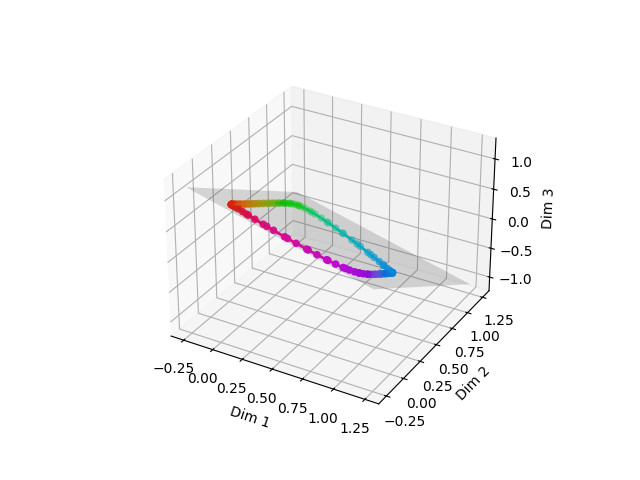

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c=intersection_rgb, s=20)

x_vals = np.linspace(-0.25, 1.25, 10)
y_vals = np.linspace(-0.25, 1.25, 10)
X, Y = np.meshgrid(x_vals, y_vals)
Z = -(a * X + b * Y + d) / (c + 10 ** (-6))
ax.plot_surface(X, Y, Z, color='gray', alpha=0.2, rstride=10, cstride=10)

start = boundary_edges[:, 0, :]
direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=2, arrow_length_ratio=0.0)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [02:20<00:00,  4.27it/s]


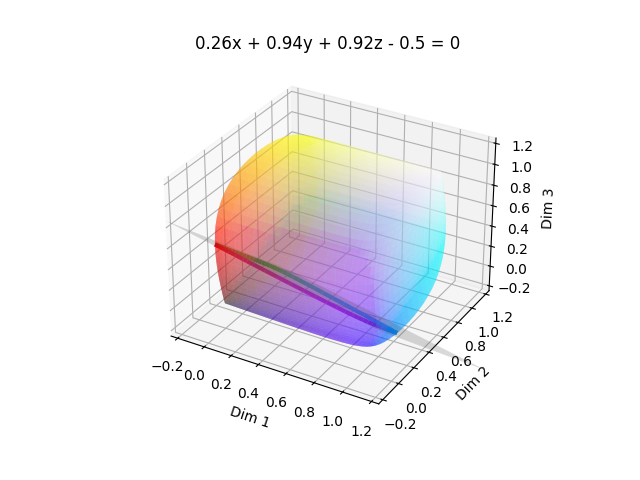

In [33]:
# This code block generates the slicing animation.

video_filename = 'object_slicing.mp4'
writer = animation.FFMpegWriter(fps=60)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with writer.saving(fig, video_filename, dpi=400):
    count = 1
    total = 600
    for t in tqdm(np.linspace(0.5, 2 * np.pi - 0.5, total)):
        # ax + by + cz + d = 0
        a = (np.sin(t) + 1) / 2  # Ranges from 0 to 1
        b = (np.cos(t) + 1) / 2  # Ranges from 0 to 1
        c = t / (2 * np.pi)      # Ranges from 0 to 1
        d = -0.5
        
        intersection_points = []
        intersection_xyz = []
        for i in range(edges.shape[0]):
            p1 = edges[i][0]
            p2 = edges[i][1]
            v = p2 - p1
            denom = a * v[0] + b * v[1] + c * v[2]
            if abs(denom) < 1e-6:    # Edge is parallel to plane.
                continue
            t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
            if 0 <= t <= 1:
                i_point = ((1 - t) * p1) + (t * p2)
                i_xyz = ((1 - t) * edges_xyz[i][0]) + (t * edges_xyz[i][1])
                intersection_points.append(i_point)
                intersection_xyz.append(i_xyz)
        assert len(intersection_points) > 0, "No intersection points"
        intersection_rgb = []
        for i_xyz in intersection_xyz:
            intersection_rgb.append(np.clip(XYZ_to_sRGB(i_xyz, illuminant=chromaticity_coord), 0, 1))
        
        # In the end, we obtain an array of points along the boundary of the intersection and their RGB values.
        intersection_points = np.array(intersection_points)
        intersection_rgb = np.array(intersection_rgb)

        vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
        projection_matrix = np.vstack((vec_a, vec_b))
        projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
        hull = ConvexHull(projected_intersection_points)
        boundary_edges = []
        boundary_colors = []
        for i in range(len(hull.vertices)):
            current_index = hull.vertices[i]
            next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
            boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
            boundary_colors.append(intersection_rgb[current_index])
        boundary_edges = np.array(boundary_edges)
        boundary_color = np.array(boundary_colors)

        ax.cla()  # Clear the previous plot
        poly3d = Poly3DCollection(faces, linewidths=0, edgecolors='k', alpha=0.4)
        poly3d.set_facecolor(face_colors)
        ax.add_collection3d(poly3d)
        x_vals = np.linspace(-0.25, 1.25, 10)
        y_vals = np.linspace(-0.25, 1.25, 10)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = -(a * X + b * Y + d) / (c + (10 ** -6))
        ax.plot_surface(X, Y, Z, color='gray', alpha=0.2, rstride=10, cstride=10)
        
        scatter = ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c=intersection_rgb, s=0)
        start = boundary_edges[:, 0, :]
        direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
        ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=3, arrow_length_ratio=0.0)
        
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        ax.set_xlim([-0.25, 1.25])
        ax.set_ylim([-0.25, 1.25])
        ax.set_zlim([-0.25, 1.25])
        ax.set_title(f"{round(a, 2)}x + {round(b, 2)}y + {round(c, 2)}z - {abs(round(d, 2))} = 0")
        # ax.set_title(f"t = {count}/{total}")

        writer.grab_frame()
        count += 1

# Optionally, show the final plot
plt.show()

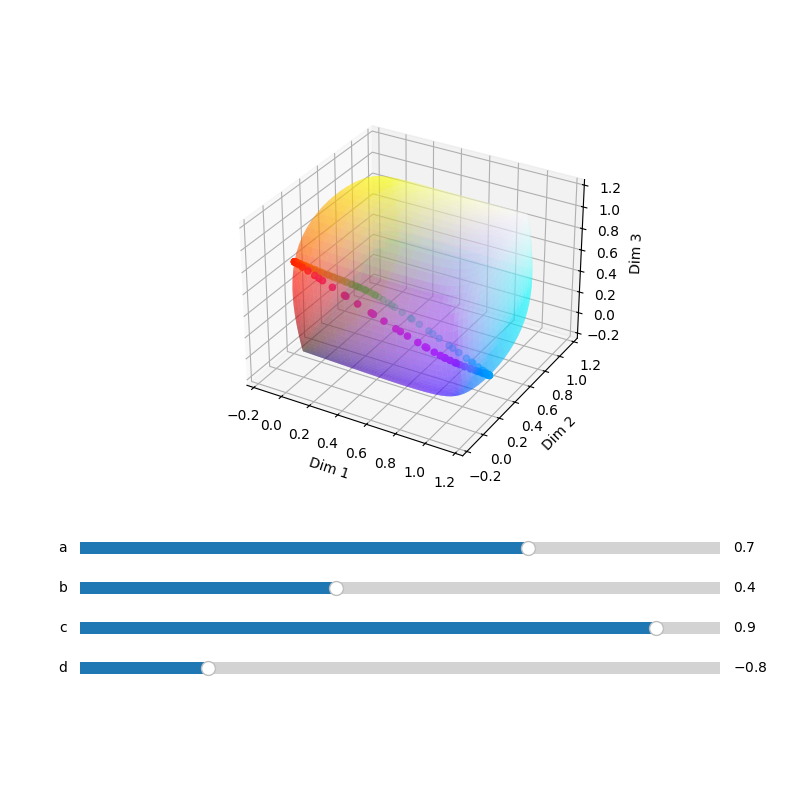

In [26]:
# This is an interactive slider where you can adjust the equation of the 2D plane and see how it intersects the solid. 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(bottom=0.4)

poly3d = Poly3DCollection(faces, linewidths=0, edgecolors='k', alpha=0.4)
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)

# Initial parameters
initial_a = 0.7
initial_b = 0.4
initial_c = 0.9
initial_d = -0.8

scatter = ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c=intersection_rgb, s=20)
# start = boundary_edges[:, 0, :]
# direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
# quiver = ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=3, arrow_length_ratio=0.0)

ax_a = plt.axes([0.1, 0.3, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_b = plt.axes([0.1, 0.25, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_c = plt.axes([0.1, 0.2, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_d = plt.axes([0.1, 0.15, 0.8, 0.03], facecolor='lightgoldenrodyellow')

# Create sliders
a_slider = Slider(ax_a, 'a', 0.0, 1.0, valinit=initial_a, valstep=0.1)
b_slider = Slider(ax_b, 'b', 0.0, 1.0, valinit=initial_b, valstep=0.1)
c_slider = Slider(ax_c, 'c', 0.0, 1.0, valinit=initial_c, valstep=0.1)
d_slider = Slider(ax_d, 'd', -1.0, 0.0, valinit=initial_d, valstep=0.1)

# Update function to change the plot when any slider value changes
def update(val):
    intersection_points = []
    intersection_xyz = []
    a = a_slider.val
    b = b_slider.val
    c = c_slider.val
    d = d_slider.val
    for i in range(edges.shape[0]):
        p1 = edges[i][0]
        p2 = edges[i][1]
        v = p2 - p1
        denom = a * v[0] + b * v[1] + c * v[2]
        if abs(denom) < 1e-6:    # Edge is parallel to plane.
            continue
        t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
        if 0 <= t <= 1:
            i_point = ((1 - t) * p1) + (t * p2)
            i_xyz = ((1 - t) * edges_xyz[i][0]) + (t * edges_xyz[i][1])
            intersection_points.append(i_point)
            intersection_xyz.append(i_xyz)
    if len(intersection_points) == 0:
        return
    intersection_rgb = []
    for i_xyz in intersection_xyz:
        intersection_rgb.append(np.clip(XYZ_to_sRGB(i_xyz, illuminant=chromaticity_coord), 0, 1))
    intersection_points = np.array(intersection_points)
    intersection_rgb = np.array(intersection_rgb)

    def find_orthogonal_vectors(normal):
        n = normal / np.linalg.norm(normal)
        # Create a vector that is not collinear with the normal
        if n[0] == 0 and n[1] == 0:
            arbitrary_vector = np.array([1, 0, 0])
        else:
            arbitrary_vector = np.array([0, 0, 1])
        vec_a = np.cross(n, arbitrary_vector)
        vec_a /= np.linalg.norm(vec_a)
        vec_b = np.cross(n, vec_a)
        vec_b /= np.linalg.norm(vec_b)
        return vec_a, vec_b
    vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
    projection_matrix = np.vstack((vec_a, vec_b))
    projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
    hull = ConvexHull(projected_intersection_points)
    boundary_edges = []
    boundary_colors = []
    for i in range(len(hull.vertices)):
        current_index = hull.vertices[i]
        next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
        boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
        boundary_colors.append(intersection_rgb[current_index])
    boundary_edges = np.array(boundary_edges)
    boundary_color = np.array(boundary_colors)

    scatter._offsets3d = (intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2])
    scatter.set_color(intersection_rgb)
    
    # start = boundary_edges[:, 0, :]
    # direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
    # quiver.remove()
    # quiver = ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=3, arrow_length_ratio=0.0)
    
    fig.canvas.draw_idle()  # Redraw the plot

# Connect the update function to each slider
a_slider.on_changed(update)
b_slider.on_changed(update)
c_slider.on_changed(update)
d_slider.on_changed(update)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

ax.set_xlim([-0.25, 1.25])
ax.set_ylim([-0.25, 1.25])
ax.set_zlim([-0.25, 1.25])

plt.show()